
# Fashion MNIST 다중 클래스 분류 (CNN 활용)

## 1. 들어가며

안녕하세요! 우리는 MNIST 손글씨 숫자 분류를 Dense(완전 연결) 레이어로 구성된 신경망으로 해결해 보았습니다. Softmax, Cross-Entropy, Adam, 미니 배치 학습, Dropout 등 다중 클래스 분류에 필요한 기본 개념과 Keras 사용법을 익혔죠.

MNIST는 비교적 간단한 데이터셋이라 기본적인 신경망으로도 높은 성능을 얻을 수 있었습니다. 하지만 세상에는 훨씬 복잡한 이미지들이 많습니다. 사물의 형태가 다양하고, 배경도 복잡하며, 이미지 크기도 클 수 있습니다. MNIST와 동일한 28x28 크기의 흑백 이미지이지만, 옷, 가방 등 패션 아이템을 분류하는 **Fashion MNIST** 데이터셋을 Dense 레이어만으로 다루어 보면 어떤 한계가 있는지 느껴볼 수 있습니다.

이번 시간에는 Fashion MNIST 데이터셋을 다루면서, **CNN(Convolutional Neural Network, 합성곱 신경망)**이 이미지 데이터 처리에 왜 강력한지 이해하고, Keras를 사용하여 간단한 CNN 모델을 구성하고 학습시켜 보겠습니다.

이 노트북에서는 다음 내용들을 학습합니다.

1.  **Fashion MNIST 데이터셋 로딩 및 이해 (MNIST와의 차이점)**
2.  **이미지 데이터 처리에 Dense 레이어만 사용하는 것의 한계**
3.  **CNN의 핵심 개념: 합성곱(Convolution), 풀링(Pooling)**
4.  **Keras로 간단한 CNN 모델 구성**
5.  **CNN 모델 학습 및 평가**

자, CNN의 세계로 들어가 봅시다!


In [1]:
# 필요한 라이브러리를 임포트합니다.
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
# CNN 관련 레이어 추가 임포트
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# 재현성을 위한 시드 설정 (선택 사항)
# np.random.seed(42)
# tf.random.set_seed(42)


## 2. Fashion MNIST 데이터셋 로딩 및 준비

Fashion MNIST 데이터셋은 MNIST와 마찬가지로 Keras에 내장되어 있어 쉽게 불러올 수 있습니다.

### 2.1 데이터 로딩


In [2]:
# Fashion MNIST 데이터셋 로딩
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

print(f"학습 이미지 형태: {train_images.shape}") # (샘플 수, 높이, 너비)
print(f"학습 레이블 형태: {train_labels.shape}") # (샘플 수)
print(f"테스트 이미지 형태: {test_images.shape}")
print(f"테스트 레이블 형태: {test_labels.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
학습 이미지 형태: (60000, 28, 28)
학습 레이블 형태: (60000,)
테스트 이미지 형태: (10000, 28, 28)
테스트 레이블 형태: (10000,)


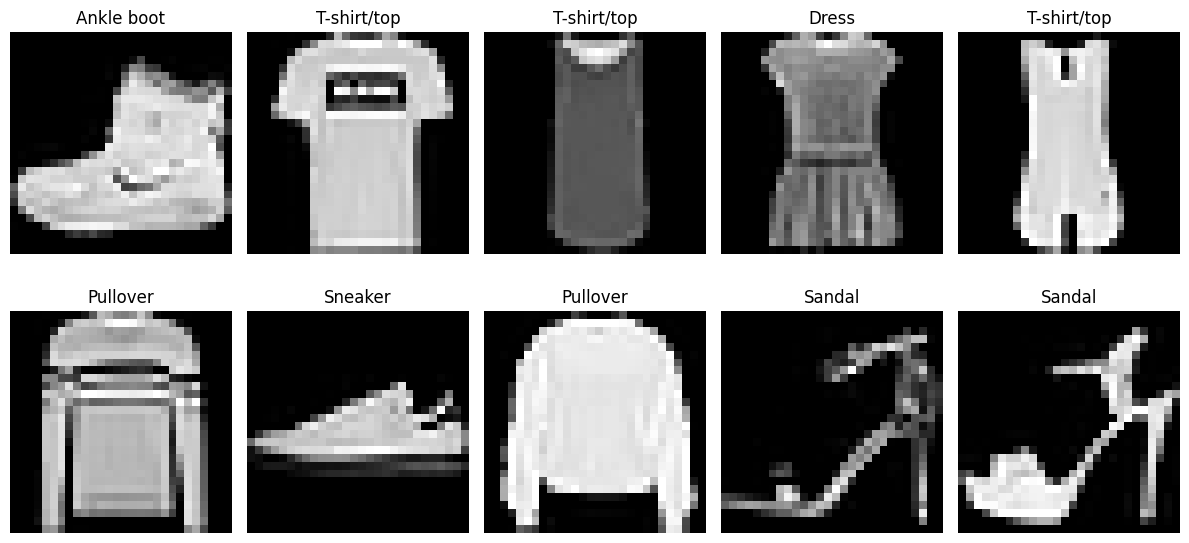

In [3]:
# Fashion MNIST 레이블 이름
fashion_mnist_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# 몇 개의 샘플 시각화
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"{fashion_mnist_labels[train_labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


이미지를 보면, 같은 'T-shirt/top' 이라도 다양한 형태와 무늬를 가질 수 있으며, 'Shirt'와 'T-shirt/top', 'Pullover'와 'Coat' 등 시각적으로 구분이 쉽지 않은 클래스들도 있습니다. MNIST의 숫자 9와 4를 구분하는 것보다 훨씬 어렵죠.

### 2.3 데이터 전처리

MNIST 때와 유사하게 데이터 전처리가 필요합니다.

1.  **픽셀 값 정규화 (Normalization):** 0~255 값을 0~1 사이로 정규화합니다.
2.  **이미지 형태 변환 (Reshaping for CNN):** CNN 레이어는 일반적으로 입력 형태로 `(높이, 너비, 채널)`을 기대합니다. Fashion MNIST는 흑백 이미지이므로 채널 수는 1입니다. 따라서 `(샘플 수, 28, 28)` 형태를 `(샘플 수, 28, 28, 1)` 형태로 바꿔줘야 합니다.
3.  **레이블 One-Hot Encoding:** Cross-Entropy 손실 함수를 위해 레이블을 원-핫 인코딩합니다.


In [4]:
# 1. 픽셀 값 정규화
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# 2. 이미지 형태 변환 (CNN 입력에 맞게 채널 차원 추가)
# (샘플 수, 높이, 너비) -> (샘플 수, 높이, 너비, 채널)
# -1은 샘플 수에 맞춰 자동으로 계산, 1은 채널 수
train_images_cnn = train_images.reshape(-1, 28, 28, 1)
test_images_cnn = test_images.reshape(-1, 28, 28, 1)

print(f"변환 후 학습 이미지 형태 (CNN): {train_images_cnn.shape}")
print(f"변환 후 테스트 이미지 형태 (CNN): {test_images_cnn.shape}")

# 3. 레이블 One-Hot Encoding
num_classes = 10
train_labels_one_hot = to_categorical(train_labels, num_classes=num_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes=num_classes)

print(f"One-Hot 인코딩 후 학습 레이블 형태: {train_labels_one_hot.shape}")

변환 후 학습 이미지 형태 (CNN): (60000, 28, 28, 1)
변환 후 테스트 이미지 형태 (CNN): (10000, 28, 28, 1)
One-Hot 인코딩 후 학습 레이블 형태: (60000, 10)



## 3. 이미지 데이터 처리에 Dense 레이어만 사용하는 것의 한계

MNIST 예제에서 우리는 28x28 이미지를 784 길이의 1차원 벡터로 펼쳐서 Dense 레이어의 입력으로 사용했습니다. Fashion MNIST에서도 동일하게 할 수 있으며, MNIST와 유사한 정확도를 얻을 수 있을 것입니다.


In [5]:
# Dense 레이어만을 사용하는 모델 구성 (참고용)
# 이미지를 1차원으로 펼쳐야 합니다.
model_dense = Sequential([
    Flatten(input_shape=(28, 28, 1)), # 28x28x1 이미지를 784 길이의 벡터로 펼침
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# 모델 요약
# model_dense.summary() # 실행해 보면 파라미터 수가 Dense 모델과 유사함을 알 수 있습니다.

# 이 모델을 Fashion MNIST에 학습시키면 MNIST보다는 정확도가 다소 낮게 나옵니다.
# 왜 그럴까요?

/Users/string/opt/anaconda3/envs/crawler-arm/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Dense 레이어는 모든 입력 뉴런이 다음 레이어의 모든 뉴런과 연결됩니다. 이미지를 1차원으로 펼치면 픽셀 간의 **공간적인 관계 (spatial relationship)** 정보가 손실됩니다. 예를 들어, 이미지에서 중요한 특징인 '엣지(edge)'나 '코너(corner)' 등은 인접한 픽셀들의 패턴으로 구성되는데, 1차원으로 펼쳐버리면 이웃 픽셀들이 벡터 상에서 멀리 떨어지게 되어 이러한 공간적인 특징을 효과적으로 학습하기 어렵습니다.

CNN은 이러한 이미지의 공간적인 구조를 보존하고 학습하기 위해 고안되었습니다.

## 4. CNN의 핵심 개념: 합성곱(Convolution), 풀링(Pooling)

![A](./cnn.png)

![Convolution 연산](https://gaussian37.github.io/assets/img/dl/concept/conv/1.gif)


### 배경지식

1. Padding
    - 이미지 주위에 0 등 값을 추가(충전재, Padding)하여 이미지의 크기를 증가시키는 것
      - 커널을 이용한 필터링 시, 외곽의 정보를 이용하기 위해 사용
2. Stride
    - 필터가 이미지를 스캔할 때 한 번에 이동하는 칸 수
    - 커널을 이동시키는 간격
3. Kernel Size
    - 필터의 크기
4. Pooling Size
    - 풀링 영역의 크기

[보다 상세한 예시 및 설명](https://gaussian37.github.io/dl-concept-covolution_operation/)


CNN은 주로 다음 두 가지 핵심 레이어로 구성됩니다.

1.  **합성곱 레이어 (Convolutional Layer, `Conv2D`):**
    *   이미지에 **필터(filter) 또는 커널(kernel)**이라는 작은 행렬을 적용하여 합성곱 연산을 수행합니다.
    *   필터는 이미지의 특정 패턴(예: 수직선, 수평선, 특정 각도의 엣지 등)을 감지하는 역할을 합니다.
    *   이미지 전체에 필터를 슬라이딩하면서 연산하여 **특징 맵(feature map)**을 생성합니다. 각 특징 맵은 원본 이미지에서 특정 패턴이 어디에 있는지(활성화되었는지)를 나타냅니다.
    *   여러 개의 필터를 사용하면 다양한 종류의 특징 맵을 얻을 수 있습니다.
    *   입력 이미지의 공간적 구조(높이, 너비)를 유지하면서 깊이(채널 수 = 필터 수)가 증가하는 형태가 됩니다.
    *   비선형성을 위해 활성화 함수(주로 ReLU)를 거칩니다.

2.  **풀링 레이어 (Pooling Layer, `MaxPooling2D`):**
    *   특징 맵의 공간적 크기(높이, 너비)를 줄이는(Downsampling) 역할을 합니다.
    *   일반적으로 Max Pooling이 사용됩니다. 일정 크기(예: 2x2)의 영역에서 가장 큰 값만 남기고 나머지는 버립니다.
    *   **왜 필요할까요?**
        *   **파라미터 수 감소:** 이미지 크기가 줄어들어 다음 레이어의 계산량과 파라미터 수가 감소합니다.
        *   **과적합 방지:** 불필요한 상세 정보를 버려 모델의 일반화 성능을 높입니다.
        *   **변환 불변성(Translational Invariance):** 특징의 위치가 이미지 상에서 약간 이동하더라도 같은 특징으로 인식하게 해주는 효과가 있습니다. (예: 눈이 얼굴 중앙에 있든 약간 옆에 있든 '눈'임을 인식).

일반적인 CNN 구조는 "Convolution -> Activation -> Pooling" 블록을 여러 개 쌓고, 마지막에 Flatten 레이어를 통해 1차원으로 펼친 후 Dense 레이어를 연결하여 최종 분류/회귀를 수행하는 형태입니다.

## 5. Keras로 간단한 CNN 모델 구성

이제 Keras를 사용하여 Fashion MNIST 분류를 위한 간단한 CNN 모델을 구성해 봅시다.


In [6]:
print("\n--- CNN 모델 구성 ---")

model_cnn = Sequential([
    # 첫 번째 합성곱 및 풀링 레이어 블록
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'),
    MaxPooling2D(pool_size=(2, 2)), # 특징 맵 크기를 절반으로 줄입니다 (28x28 -> 14x14)

    # 두 번째 합성곱 및 풀링 레이어 블록
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)), # 특징 맵 크기를 또 절반으로 줄입니다 (14x14 -> 7x7)

    # CNN 블록의 출력을 1차원으로 펼침 (Dense 레이어에 연결하기 위해)
    Flatten(), # 7x7x64 = 3136 차원의 벡터가 됩니다.

    # Dense 레이어 (MNIST Dense 모델과 유사)
    Dense(128, activation='relu'),

    # 과적합 방지를 위한 Dropout (선택 사항)
    # Dropout(0.2),

    # 출력층
    Dense(num_classes, activation='softmax')
])

# 모델 요약
model_cnn.summary()


--- CNN 모델 구성 ---


/Users/string/opt/anaconda3/envs/crawler-arm/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)


모델 요약을 보면 각 레이어를 통과하면서 텐서(특징 맵)의 형태가 어떻게 변하는지 알 수 있습니다.

*   `Conv2D` 레이어는 `(높이, 너비, 채널)` 형태를 유지하며 채널 수(`filters`)만 증가합니다. `padding='same'`은 출력 크기가 입력 크기와 같도록 가장자리에 0을 채워줍니다. `kernel_size=(3, 3)`은 3x3 필터를 사용한다는 의미입니다.
*   `MaxPooling2D((2, 2))` 레이어는 높이와 너비 크기를 각각 절반으로 줄입니다.
*   `Flatten` 레이어는 이전 레이어의 3차원 텐서(`(7, 7, 64)`)를 1차원 벡터(`(3136,)`)로 변환합니다.
*   그 이후는 기존 Dense 모델과 동일한 구조입니다.

CNN 레이어의 파라미터 수는 Dense 레이어에 비해 적을 수 있지만, 특징 맵을 생성하는 과정에서 이미지의 공간 정보를 효과적으로 활용할 수 있습니다.

## 6. CNN 모델 컴파일 및 학습

모델 컴파일 과정은 Dense 모델과 동일합니다. 다중 클래스 분류이므로 `categorical_crossentropy` 손실 함수와 `adam` 옵티마이저를 사용합니다.


In [ ]:
# 모델 컴파일
model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print("CNN 모델 컴파일 완료!")

print("\nCNN 모델 학습 시작...")
# CNN 모델 학습 (MNIST 때보다 에포크를 조금 늘려볼 수 있습니다)
history_cnn = model_cnn.fit(train_images_cnn, train_labels_one_hot,
                            epochs=10,        # 학습 에포크 수
                            batch_size=64,    # 미니 배치 크기 (늘려도 메모리 허용 시 가능)
                            verbose=1)

print("CNN 모델 학습 완료!")

CNN 모델 컴파일 완료!

CNN 모델 학습 시작...
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.7776 - loss: 0.6186
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.8907 - loss: 0.3038
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.9079 - loss: 0.2523
Epoch 4/10
102/938 ━━━━━━━━━━━━━━━━━━━━ 1:44 125ms/step - accuracy: 0.9169 - loss: 0.2173


학습이 진행되면서 손실이 줄어들고 정확도가 올라가는 것을 확인합니다. CNN은 이미지의 특징을 더 효과적으로 학습하기 때문에, Dense 모델보다 동일한 에포크에서 더 높은 정확도에 도달하거나 더 안정적으로 학습될 가능성이 높습니다.

### 학습 과정 시각화

학습 과정 동안의 손실과 정확도를 그래프로 확인해 봅시다.


In [ ]:
# 학습 과정 시각화
plt.figure(figsize=(12, 4))

# 손실(Loss) 그래프
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'])
plt.title('CNN Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)

# 정확도(Accuracy) 그래프
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'])
plt.title('CNN Model Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)

plt.show()


## 7. CNN 모델 평가

학습된 CNN 모델의 성능을 테스트 데이터셋으로 평가합니다.


In [ ]:
print("\nCNN 모델 평가 시작...")
# 테스트 데이터(test_images_cnn, test_labels_one_hot)로 모델 평가
loss_cnn, accuracy_cnn = model_cnn.evaluate(test_images_cnn, test_labels_one_hot, verbose=0)

print(f"CNN 모델 테스트 손실(Loss): {loss_cnn:.4f}")
print(f"CNN 모델 테스트 정확도(Accuracy): {accuracy_cnn:.4f}")
print("CNN 모델 평가 완료!")


일반적으로 Fashion MNIST에서 CNN 모델은 Dense 모델보다 높은 테스트 정확도를 보여줄 것입니다. 이는 CNN이 이미지의 공간적 특징을 잘 포착했기 때문입니다.

## 8. CNN 모델 예측

학습된 CNN 모델을 사용하여 예측을 수행해 봅시다. `model.predict()` 함수를 사용하며, 입력 형태는 `(샘플 수, 높이, 너비, 채널)`이어야 합니다.


In [ ]:
# 테스트 데이터셋의 처음 5개 이미지에 대해 예측
predictions_cnn = model_cnn.predict(test_images_cnn[:5])

print("\n처음 5개 테스트 이미지 예측 결과 (CNN):")
# 예측 결과 (확률 분포)를 실제 예측 클래스 (가장 확률 높은 클래스 인덱스)로 변환
predicted_classes_cnn = np.argmax(predictions_cnn, axis=1)

print(f"예측된 클래스 (처음 5개): {predicted_classes_cnn}")
print(f"실제 레이블 (처음 5개): {test_labels[:5]}") # 원본 정수 레이블과 비교

# 예측 결과 시각화
plt.figure(figsize=(12, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    # 원본 이미지 형태 (28, 28)로 되돌려서 시각화 (채널 차원 제거)
    plt.imshow(test_images[i].squeeze(), cmap='gray') # .squeeze()는 차원 크기가 1인 차원 제거
    plt.title(f"Pred: {fashion_mnist_labels[predicted_classes_cnn[i]]}\nTrue: {fashion_mnist_labels[test_labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


시각화된 예측 결과를 통해 모델이 이미지를 얼마나 잘 분류했는지 직관적으로 확인할 수 있습니다.

## 9. 마치며

이번 노트북을 통해 Fashion MNIST 데이터셋을 다루면서 이미지 처리에 특화된 CNN 모델의 기본 구성 요소(합성곱 레이어, 풀링 레이어)와 Keras에서의 사용법을 익혔습니다. 이미지의 공간 정보를 효과적으로 학습하는 CNN 덕분에 MNIST보다 어려운 Fashion MNIST 데이터셋에서도 좋은 성능을 얻을 수 있었습니다.

CNN은 이미지 인식 분야에서 필수적인 기술입니다. 여기서 더 나아가 다음과 같은 학습을 이어갈 수 있습니다.

*   **더 복잡한 CNN 아키텍처:** Conv-Pool 블록을 더 깊게 쌓거나, Conv 레이어의 필터 수를 늘려보세요.
*   **다른 이미지 데이터셋 적용:** CIFAR-10, CIFAR-100 등 컬러 이미지 데이터셋으로 CNN을 적용해 보세요. (이때는 입력 형태가 (높이, 너비, 3)이 됩니다.)
*   **추가 CNN 기법:** 배치 정규화(Batch Normalization), 다양한 형태의 풀링(Average Pooling), 다양한 합성곱(Dilated Conv, Depthwise Conv 등) 등을 학습합니다.
*   **Pre-trained Model (사전 학습 모델):** 대규모 이미지 데이터셋(ImageNet 등)으로 미리 학습된 복잡한 CNN 모델을 가져와서 내 문제에 맞게 미세 조정(Fine-tuning)하는 기법을 배웁니다. (ResNet, VGG, Inception 등 유명 모델들)
*   **PyTorch로 CNN 구현:** PyTorch로도 동일한 CNN 모델을 직접 구현해 보면서 두 프레임워크의 차이점을 비교해 보세요.